In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5

In [2]:
from subprocess import check_output
print(check_output(["ls", "./dataset/regression"]).decode("utf8"))

bank32nh.data
bank8FM.data
bostonhousing
cal_housing.data
cpu_act.data
cpu_small.data
house_16H.data
house_8L.data



In [3]:
train_df = pd.read_csv("./dataset/regression/bank32nh.data", sep=' ', header=None)
train_df=train_df.drop(train_df.columns[-1],axis=1)
print(train_df.shape)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

(8192, 33)


(8192, 33)

In [4]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,label
0,0.413010,0.607442,0.332608,0.406812,-0.151224,1.525222,-0.144368,0.852368,0.412397,1.728169,-0.449231,4.078482,0.232042,-0.323190,0.792235,0.421474,-0.307503,3.086689,0.363949,0.441308,-0.276851,2.0,1.974706,-0.776759,-0.783770,8.0,0.603486,-0.997118,-0.502138,5.0,1.169388,9.0,0.049118
1,-0.602384,0.350618,0.429196,0.414476,-0.124489,4.597991,0.579458,0.651134,0.104394,0.636356,-0.283787,3.546643,0.115860,0.409074,2.152997,0.758680,0.341127,1.478951,0.662488,0.462398,0.339673,6.0,0.798979,-0.002820,-0.080542,2.0,1.125542,-0.983397,-0.107632,5.0,1.186039,7.0,0.242579
2,-0.322881,-0.538491,1.602260,0.039605,0.196023,1.909005,-0.675672,0.963618,0.147458,1.414008,0.495453,0.056459,-0.163151,0.350221,1.124090,1.398160,-0.456921,1.600723,0.650252,-0.247380,0.318002,3.0,0.577355,-0.952645,-0.571600,5.0,1.280392,0.771129,-0.665756,5.0,1.024203,6.0,0.000000
3,-0.233570,-0.936451,1.710192,2.179527,0.438461,4.742055,-0.163625,-0.923273,0.597622,0.118409,0.229981,3.209085,-0.165046,0.012872,0.398148,1.335824,0.119910,13.070052,0.308221,-0.743841,0.258362,4.0,0.760084,-0.198235,-0.205276,2.0,0.509727,-0.579544,0.480094,6.0,1.568492,7.0,0.469045
4,0.403126,0.313367,0.822382,1.393975,0.253435,9.398630,0.312528,0.288321,0.431867,0.110369,0.294665,1.274100,0.328350,-0.288962,0.067075,0.632938,0.148618,3.633846,0.233204,-0.685285,-0.758206,6.0,1.170067,0.573352,0.315217,2.0,0.622033,-0.134747,0.669948,3.0,1.295913,9.0,0.000000


1638.4
[0.0, 0.0001, 0.012395000000000002, 0.051264999999999998, 0.15377600000000002, 1.8201649999999998]
[False False  True ..., False False False]
[False False False ...,  True False False]
[ True False False ..., False  True False]
[False False False ..., False False  True]
[False  True False ..., False False False]
[ 2.  4.  0. ...,  1.  2.  3.]
      feat0     feat1     feat2     feat3     feat4     feat5     feat6  \
0  0.413010  0.607442  0.332608  0.406812 -0.151224  1.525222 -0.144368   
1 -0.602384  0.350618  0.429196  0.414476 -0.124489  4.597991  0.579458   
2 -0.322881 -0.538491  1.602260  0.039605  0.196023  1.909005 -0.675672   
3 -0.233570 -0.936451  1.710192  2.179527  0.438461  4.742055 -0.163625   
4  0.403126  0.313367  0.822382  1.393975  0.253435  9.398630  0.312528   

      feat7     feat8     feat9    feat10    feat11    feat12    feat13  \
0  0.852368  0.412397  1.728169 -0.449231  4.078482  0.232042 -0.323190   
1  0.651134  0.104394  0.636356 -0.283787  3.54

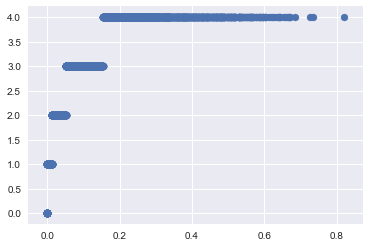

In [5]:
#train_df['label_ord']=train_df['label']
label=train_df.label.values
sorted_idx=np.argsort(train_df.label.values)
num_samples_per_class=train_df.shape[0]/num_classes
print(num_samples_per_class)

bins=[(k*1e-4+label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]]) for k in range(1,num_classes+1)]
bins.insert(0,0.0)
bins[-1]=bins[-1]+1
print(bins)

label_ord=label.copy()
for k in range(num_classes):
    print(np.all([label>=bins[k], label<bins[k+1]],0))
    label_ord[np.all([label>=bins[k], label<bins[k+1]],0)]=k
    
print(label_ord)


train_df['label_ord']=label_ord
print(train_df.head())

plt.scatter(label,label_ord)
plt.show()


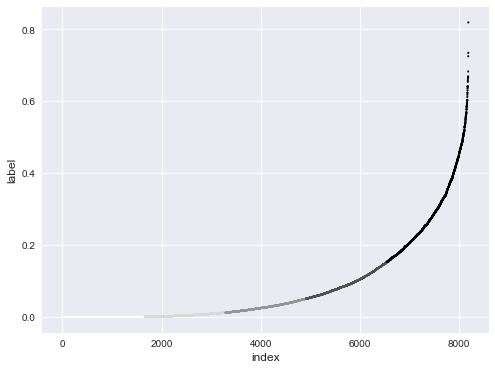

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), label[sorted_idx],s=3,c=np.sort(label_ord[sorted_idx]))
plt.xlabel('index', fontsize=12)
plt.ylabel('label', fontsize=12)


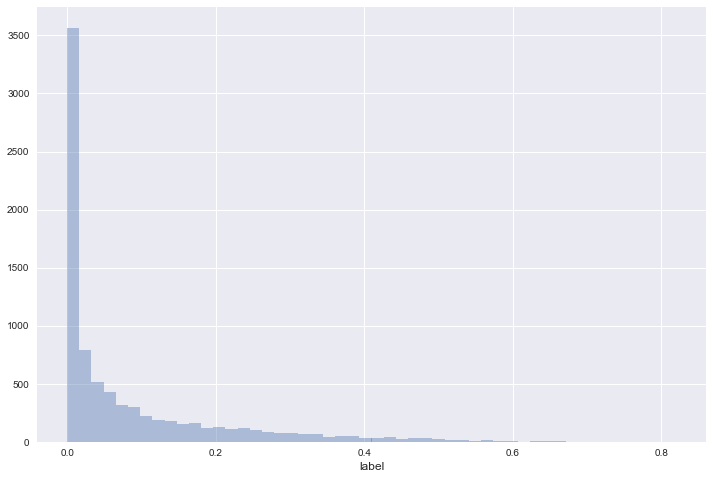

In [7]:
'''ulimit = np.percentile(train_df.label.values, 98)
llimit = np.percentile(train_df.label.values, 2)
train_df['label'].ix[train_df['label']>ulimit] = ulimit
train_df['label'].ix[train_df['label']<llimit] = llimit'''

plt.figure(figsize=(12,8))
sns.distplot(train_df.label.values, bins=50, kde=False)
plt.xlabel('label', fontsize=12)


# Training - Validation Split

In [8]:
feat=train_df.values[:,:-2]

#Normalize the features

feat_max = np.amax(feat,axis=0)
feat_min = np.amin(feat,axis=0)

feat=(feat-feat_min)/(feat_max-feat_min)
feat=feat*2-1

'''feat_mean = np.mean(feat,axis=0)
feat_std = np.std(feat,axis=0)

feat=(feat-feat_mean)/feat_std
'''
label_ord=train_df.values[:,-1].astype(np.int)

print(np.mean(feat,axis=0))
print(np.min(feat,axis=0))
print(feat.shape)
print(label_ord)

fvec=feat.copy()
#label=np.eye(num_classes)[label_ord]
#print(label)


[ -3.46686086e-03  -9.20904637e-04  -8.03606985e-01  -7.73078363e-01
  -3.56635604e-03  -7.72843486e-01  -1.18393606e-04  -9.97569510e-04
  -7.48644283e-01  -8.52985102e-01  -2.84872124e-03  -7.72901335e-01
  -6.64816878e-03  -1.01483779e-03  -7.10571434e-01  -7.82965571e-01
  -5.51937200e-03  -8.13909000e-01   6.02760301e-03   6.02673678e-03
   1.52910570e-03  -3.44319661e-01  -2.20519716e-03  -1.63086888e-02
   1.64501047e-03  -3.35123698e-01  -3.73533559e-03   8.63693798e-04
   1.63181312e-03  -3.29711914e-01  -1.04553928e-02   1.46484375e-03]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(8192, 32)
[2 4 0 ..., 1 2 3]


In [9]:
test_size = 1000

test_idx=sorted_idx[np.floor(np.linspace(0,len(label_ord)-1,test_size)).astype(np.int)]
train_idx = np.setdiff1d(np.arange(0,len(label_ord)),test_idx)



label_ord_test=label_ord[test_idx]
label_ord_train=label_ord[train_idx]
#label_test=np.eye(num_classes)[label_ord_test]
#label_train=np.eye(num_classes)[label_ord_train]
fvec_test=fvec[test_idx,:]
fvec_train=fvec[train_idx,:]

print(label_ord_test.shape)
print(label_ord_train.shape)
print(fvec_test.shape)
print(fvec_train.shape)

(1000,)
(7192,)
(1000, 32)
(7192, 32)


In [10]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error

# Create linear regression object
regr = linear_model.Ridge(alpha = .5)

# Train the model using training sets
regr.fit(fvec_train, label_ord_train)

# Make predictions using the testing set
label_ord_pred = np.round(regr.predict(fvec_test)).astype(np.int)
label_ord_pred[label_ord_pred<0]=0
label_ord_pred[label_ord_pred>=num_classes]=num_classes-1

label_ord_tr_pred = np.round(regr.predict(fvec_train)).astype(np.int)
label_ord_tr_pred[label_ord_tr_pred<0]=0
label_ord_tr_pred[label_ord_tr_pred>=num_classes]=num_classes-1

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Training')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_tr_pred, label_ord_train))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_tr_pred==label_ord_train))

# The mean squared error
print('Validation')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_pred, label_ord_test))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_pred==label_ord_test))

Coefficients: 
 [ -1.88317491e-02   1.64733924e-02  -1.00358358e-01  -7.12058869e-02
  -1.01446282e-02   2.00886136e+00   7.72151419e-03   1.67966693e-03
  -1.51213653e-01  -3.32255414e-01  -3.06772015e-03   3.00310220e+00
  -1.85726251e-02   3.62893444e-02  -9.81725267e-02  -6.81625413e-02
   1.99362178e-03   2.35966383e+00  -1.72680852e-01   2.79800411e-03
  -9.64941303e-03   1.53275991e-01  -1.90156013e-01  -3.18897837e-02
  -5.37415994e-02   2.62896193e-01  -2.63141216e-02  -1.45610755e-02
   2.80541112e-02   3.04330277e-01   1.19621218e-02  -5.93394855e-01]
Training
Mean absolute error: 0.74
Accuracy: 0.38
Validation
Mean absolute error: 0.72
Accuracy: 0.39


In [11]:

from sklearn.svm import SVC
clf = SVC()

clf.fit(fvec_train, label_ord_train)
label_ord_pred = clf.predict(fvec_test)
label_ord_tr_pred = clf.predict(fvec_train)
print(np.histogram(label_ord_pred))
print(np.histogram(label_ord_test))


# The coefficients
print('Coefficients: \n', regr.coef_)


# The mean squared error
print('Training')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_tr_pred, label_ord_train))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_tr_pred==label_ord_train))

# The mean squared error
print('Validation')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_pred, label_ord_test))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_pred==label_ord_test))

(array([241,   0, 181,   0,   0, 221,   0, 174,   0, 183]), array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]))
(array([203,   0, 199,   0,   0, 199,   0, 199,   0, 200]), array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]))
Coefficients: 
 [ -1.88317491e-02   1.64733924e-02  -1.00358358e-01  -7.12058869e-02
  -1.01446282e-02   2.00886136e+00   7.72151419e-03   1.67966693e-03
  -1.51213653e-01  -3.32255414e-01  -3.06772015e-03   3.00310220e+00
  -1.85726251e-02   3.62893444e-02  -9.81725267e-02  -6.81625413e-02
   1.99362178e-03   2.35966383e+00  -1.72680852e-01   2.79800411e-03
  -9.64941303e-03   1.53275991e-01  -1.90156013e-01  -3.18897837e-02
  -5.37415994e-02   2.62896193e-01  -2.63141216e-02  -1.45610755e-02
   2.80541112e-02   3.04330277e-01   1.19621218e-02  -5.93394855e-01]
Training
Mean absolute error: 0.69
Accuracy: 0.53
Validation
Mean absolute error: 0.79
Accuracy: 0.45


# MLP Network

In [13]:
import tensorflow as tf

label_test=np.eye(num_classes)[label_ord_test]
label_train=np.eye(num_classes)[label_ord_train]

In [14]:
def mlp(x, hidden_sizes, activation_fn=tf.nn.relu,dropout_rate=.5,std_dev=1.0):
    if not isinstance(hidden_sizes, (list, tuple)):
        raise ValueError("hidden_sizes must be a list or a tuple")
        
    scope_args = {'initializer': tf.random_normal_initializer(stddev=std_dev)}
    
    for k in range(len(hidden_sizes)-1):
        layer_name="weights"+str(k)
        #FC layers
        with tf.variable_scope(layer_name, **scope_args):
            W = tf.get_variable('W', shape=[x.shape[-1], hidden_sizes[k]])
            b = tf.get_variable('b', shape=[hidden_sizes[k]])
            x = activation_fn(tf.matmul(x, W) + b)
            #Dropout before the last layer
            x = tf.nn.dropout(x, keep_prob=dropout_rate)
    #Softmax layer
    with tf.variable_scope('outlayer', **scope_args):
        W = tf.get_variable('W', shape=[x.shape[-1], hidden_sizes[-1]])
        b = tf.get_variable('b', shape=[hidden_sizes[-1]])
        return tf.matmul(x, W) + b

In [17]:
'''fvec_n=fvec/np.round(np.max(label))
label_n = label/np.round(np.max(label))'''
def test_classification(model_function, learning_rate=0.1,num_iter=30000,num_log=2000):

    with tf.Graph().as_default() as g:
        # where are you going to allocate memory and perform computations
        with tf.device("/cpu:0"):
            
            # define model "input placeholders", i.e. variables that are
            # going to be substituted with input data on train/test time
            x_ = tf.placeholder(tf.float32, [None, fvec.shape[1]])
            y_ = tf.placeholder(tf.float32, [None, num_classes])
            y_logits = model_function(x_)
            

            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_logits))
            '''train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)'''
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
           
            y_pred = tf.argmax(y_logits, 1)
            y_true = tf.argmax(y_,1)
            correct_prediction = tf.equal(y_pred, y_true)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            mae_error = tf.reduce_mean(tf.cast(tf.abs(y_pred-y_true), tf.float32))

    with g.as_default(), tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        
        # train
        ids=[i for i in range(128)]
        for iter_i in range(num_iter+1):
            batch_xs = fvec_train[ids,:] 
            batch_ys = label_train[ids]
            ids=[(ids[0]+100+i)%label_train.shape[0] for i in range(100)]
            sess.run(train_step, feed_dict={x_: batch_xs, y_: batch_ys})
            
            # test trained model
            if iter_i % num_log == 0:
                tf_feed_dict = {x_: fvec_train, y_: label_train}
                loss_tr, acc_tr, mae_tr, y_pred_tr,y_true_tr= sess.run(
                    [loss, accuracy, mae_error, y_pred,y_true], feed_dict=tf_feed_dict)
                tf_feed_dict = {x_: fvec_test, y_: label_test}
                loss_val, acc_val, mae_val, y_pred_val,y_true_val= sess.run(
                    [loss, accuracy, mae_error, y_pred,y_true], feed_dict=tf_feed_dict)
                print('iteration %d\t Training: loss: %.5f\t MAE: %.5f\t acc: %.5f\t, Validation: loss: %.5f\t MAE: %.5f\t acc: %.5f\t'%
                      (iter_i, loss_tr, mae_tr, acc_tr, loss_val, mae_val, acc_val))
                '''loss_val= sess.run(loss, feed_dict=tf_feed_dict)
                print('iteration %d\t loss: %.5f\t MAE: %.5f\t acc: %.5f\t'%
                      (iter_i, loss_val, loss_val, loss_val))'''

In [18]:
test_classification(
    lambda x: mlp(x, [32, 16, 16, 12, 12, 8, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=1e-3,num_iter=100000,num_log=2000)


iteration 0	 Training: loss: 1.61273	 MAE: 1.35623	 acc: 0.19702	, Validation: loss: 1.61241	 MAE: 1.35700	 acc: 0.19200	
iteration 2000	 Training: loss: 1.47498	 MAE: 1.13140	 acc: 0.35053	, Validation: loss: 1.44077	 MAE: 1.10400	 acc: 0.36000	
iteration 4000	 Training: loss: 1.42999	 MAE: 1.10428	 acc: 0.35428	, Validation: loss: 1.45174	 MAE: 1.10300	 acc: 0.35800	
iteration 6000	 Training: loss: 1.40367	 MAE: 0.99486	 acc: 0.37625	, Validation: loss: 1.37136	 MAE: 0.93600	 acc: 0.40500	
iteration 8000	 Training: loss: 1.38688	 MAE: 0.99819	 acc: 0.38181	, Validation: loss: 1.45761	 MAE: 0.96700	 acc: 0.39100	


KeyboardInterrupt: 

In [ ]:
test_classification(
    lambda x: mlp(x, [32, 16, 12, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=1e-3,num_iter=500000,num_log=10000)
test_classification(
    lambda x: mlp(x, [32, 16, 12, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=1e-4,num_iter=500000,num_log=10000)
test_classification(
    lambda x: mlp(x, [32, 16, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=1e-3,num_iter=500000,num_log=10000)

In [ ]:
test_classification(
    lambda x: mlp(x, [16, 12, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=1e-3,num_iter=1000000,num_log=10000)


In [ ]:
test_classification(
    lambda x: mlp(x, [16, 12, 8, 5], activation_fn=tf.nn.relu,std_dev=.1), 
    learning_rate=5e-4,num_iter=300000,num_log=10000)